# Base Code for HW 12 Challenge Model YTNA - Smith

## Model Description 
- This is a three layered model, with an West->East stream flowing over our specified topography. This case has the town pumping well added.

#### Dimensions: 
- 50 by 50 by 3
- dx = dy = 1000 m 

#### Topography
- top layer is defined in our BASE_top_elev.csv file
- bottom layer is 40m thick, with a flat 5m middle layer above it

#### Subsurface Properties: 
- Homogeneous within each of three layers
- K top and bottom layers = 8.5 m/day in x, y and z.
- K middle layer = same as top and bottom for leftmost 20 columns
- K middle layer: 0.0001 m/day in z direction for rightmost 30 columns
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001

#### Boundary Conditions: 
 - No flow on left, top, and bottom boundaries
 - right boundary is set at a constant head of 70m
 
#### Well: 
 - one well pumping 1810 m^3 @ bottom layer (21,38)
 - localized recharge at cell 25 along stream

#### Stream properties
 - Inflow = 0 m3/d
- Streambed slope = 0.001 m/m
- Streambed roughness = 0.04
- Streambed width = 1 m
- Streambed K = 1.36 x horizontal K of top layer
- Streambed thickness = 1 m
- Stage = 0.5 m
- Segments = 3
     

## 1. Setup the environment

In [49]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [50]:
modelname = "Base_Code_1"
moddir="C:\\Users\sitzk\Desktop\GW_Modelling\mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

nrow = 50
ncol = 50

dx = 1000
dy = 1000

nlay=3  #3 layers

#dz = (ztop - zbot) / nlay
#Lx = dx*ncol
#Ly = dy*nrow

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow,ncol)
# print(type(ztop))
zbot = 0

K_horiz = 8.5    #assign horizontal hydraulic conductivity 
K_vert = 8.5    #assign vertical hydraulic conductivity (along z axis)

Ss = 0.0001
n = 0.1 
Sy = 0.1 
uncnf = 1

## Setting up Layer properties

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 40.                  # bottom elevation of middle layer (1) is 40 m
botm[0,:,:] = 45.                  # bottom elevation of top layer (0) is 45 m 

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:] = 0.0001                   # Replace the K in the middle layer with the lower value for 30 R columns

Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
#Kh[1,:,21:-1] = 0.0001                    # Horizontal K does not change

#model timing (1stress period)
nper = 1
steady = [True]


#Create dis object
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)   #Model unit meters (lenuni = 2) and days (itmuni = 4)

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
C:\Users\sitzk\AppData\Local\Temp\ipykernel_18836\2247869631.py:2: DeprecationWarning: invalid escape sequence \s
  moddir="C:\\Users\sitzk\Desktop\GW_Modelling\mf2005.exe"


## 4. boundaries

- I also had some help here getting the bedrock right

In [51]:
#Create bas object
# Our Boundary Conditions 
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = 0 # whole left side is no flow
ibound[:, :, -1] = -1 # whole right side constant head
ibound[:, 0, :] = 0 # first row (top of domain) is no flow
ibound[:, -1, :] = 0 # last row (bottom of domain) is no flow
for i in range (0,6):
    ibound[0:, i, 0:6-i] = 0
for i in range (0,8):
    ibound[1, i, 0:8-i] = 0
for i in range (0,10):
    ibound[2, i, 0:10-i] = 0      # setting bedrock in the appropriate layers
for i in range (0,6):
    ibound[0:, 44+i, 0:1+i] = 0
for i in range (0,8):
    ibound[1, 42+i, 0:1+i] = 0
for i in range (0,10):
    ibound[2, 40+i, 0:1+1] = 0

#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
h_right = 70
H_init[:, :, :] = h_right    #initialize the entire domain to the right head value


bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m)


lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53) 



## recharge & ET

For some reason, recharge seems to break my model, and my solution cannot converge, so I left it commented out


In [52]:
# Rch object
#recharge = 4e-5 #m/day
#rech_zone = np.zeros((nrow,ncol))
#rech_zone[:, 0:15] = rech_zone[:, 0:15] + recharge                # we want recharge in our first 15 columns only
#rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)


ET_zone = np.zeros((nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[:,25:-1] = 1e-5  # ET strictly on right half of model
ET_zone[21:28,:] = 5e-4  #stream ET as given
extinction_depth = 1 #extinction depth is the depth where ET no longer occurs below our land surface

evt = flopy.modflow.mfevt.ModflowEvt(model=m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) #ipakcb makes sure it applies to water balance of all cells, default is 0, 53 is a safe integer to choose, some are taken 

#create  output control object 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

print(ET_zone)


[[0.e+00 0.e+00 0.e+00 ... 1.e-05 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 1.e-05 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 1.e-05 1.e-05 0.e+00]
 ...
 [0.e+00 0.e+00 0.e+00 ... 1.e-05 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 1.e-05 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 ... 1.e-05 1.e-05 0.e+00]]


## Well

In [53]:
#Well setup
pumping = -1810 #m3/day  #given
well_loc = (2,21,38) #Well loc should be layer, row, column
well_1 = [i for i in well_loc] + [pumping]
print(well_1)
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]} #putting the well in the bottom layer

wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

[2, 21, 38, -1810]
Well 1 [layer, row, column, flux]: 
 [2, 21, 38, -1810]


## Stream
- I just got this from the powerpoint slides that were provided, it gave me no issues... I think

In [54]:
# User inputs:
k_strbott = 1.36 * K_horiz                      #river bottom hydraulic conductivity in f/d
sed_thick = 1                      #thickness of riverbed sediment in f
slope = 0.001                        #slope of streambed (m/m)
rough = 0.04                         #roughness of streambed
width = 1                           #x-sectional width of channel (m)
Flow_into_the_1st_reach = 0    # m^3/day
Stage_above_datum = 0.5 # m^3/day; top of streambed is at 8 m (incl 1 m of streambed thickness)

# str settings
set_icalc = 0                   #1 if the stage is to be calculated based on flow, otherwise specify below # Set icalc = 0 bc stage doesn't change
str_spd1 = []                      #create list to store all river cells for stress period 1
const = 86400.0                      #multiplication constant for m3/day - see documentation for other units
istcb2 = 53                          #save outflows to cbb file

#Setup the stream characteristics 
return_loc = 25
ntrib = 2

#Setup the reach locations – here the row value will be 25 for each reach and the column values will go from 0-49
nreach =  50   # river extending the width of the domain
str_rows = 25*np.ones((nreach),dtype=np.int32)  # integer array of row #s for each reach 
str_cols = np.arange(0,nreach)  # integer array of col #s for each reach 

#Setup the inflows for the reaches
Qreturn =0     # return flow from the town
reach_flow = np.zeros((nreach),dtype=np.int32)  # initially set all inflows to zero for all reaches
reach_flow[return_loc] = Qreturn # inflow to seg2 = return from town
reach_flow[return_loc+1] = -1 # inflow to seg3 = sum of all previous segs

#setup segment numbers – this is a list of segment values that goes with each reach
return_loc = 24    #specifying the column where the town return flows come in
segments = np.ones((nreach),dtype=np.int32)    # make a segment array that is nreach long and initialize all the values to 1
segments[return_loc] = 2    #Change the segment number to ‘2’ where the town recharge comes in
segments[return_loc+1:nreach] = 3    # Change the segment number to ‘3’ everywhere downstream of the the town well

#setup reach numbers – this will be the numbering of the reaches within each segment. 
# Recall that numbering starts and one and increases moving downstream
reaches = np.arange(1,nreach+1)   # create an array of reach #s counting from 1-50
reaches[return_loc] = 1    # reassign the reach number to be 1 for segment 2
reaches[return_loc+1:nreach] = np.arange(1,nreach-(return_loc+1)+1)  # reassign the reach numbers for segment 3 to start counting at 1

# Stream Elevation
ztop = np.genfromtxt('BASE_top_elev.csv', delimiter=',') # top elevation of top layer (import from csv file) (dim: nrow, ncol)
surf_elev = np.zeros((nreach))   # create array of zeros the length of the stream

# loop over the stream reaches and pull the land surface elevation for the location of each stream cell
for i in np.arange(nreach): 
      surf_elev[i] = ztop[str_rows[i],str_cols[i]]

Stop = surf_elev -1    # elevation of the top of the streambed (1 m below land surface) (m)
Sbot = Stop - sed_thick      # elevation of the bottom of the streambed (m)
stage_elev = Stop + Stage_above_datum       # elevation of the water surface in the stream (m)


#Setup the stress period dictionary
str_info = np.zeros((nreach,13)) # create array of zeros for reaches, each reach requires 13 input values

# Loop over the reaches and setup the data
for r in np.arange(nreach): 
     str_info[r,:] = [0, str_rows[r], str_cols[r], segments[r], reaches[r], reach_flow[r], stage_elev[r], k_strbott, Sbot[r], Stop[r], width,  slope, rough]
str_spd = {0: str_info} # save the stream info in a stress period dictionary


#Setup the segments dictionary
#for each segment, need an array of 10 zeros, for last segment, first two values are seg #s of upstream segments
nseg = 3
icalc = 1
seg_info = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
str_segd = {0: seg_info}  #save the stream info in a segment dictionary

# Setup the mudflow package call
strm = flopy.modflow.mfstr.ModflowStr(m, mxacts=nreach, nss=nseg, ntrib=ntrib, ndiv=0, icalc=icalc, const=const, ipakcb=53, istcb2=53, dtype=None, stress_period_data=str_spd, segment_data=str_segd, extension='str')



run model

In [55]:
m.write_input()

success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: C:\Users\sitzk\Desktop\GW_Modelling\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Base_Code_1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 21:06:43

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/04/21 21:06:43
 Elapsed run time:  0.109 Seconds

  Normal termination of simulation


# 5. Plot the domains
### 5.1 Plan view of the domain

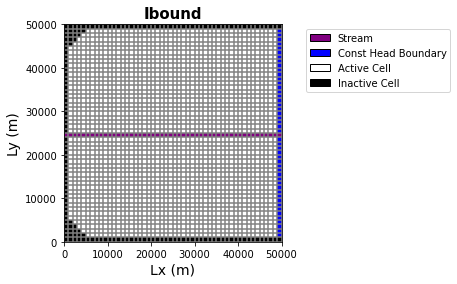

In [56]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
#wel_m = modelmap.plot_bc("WEL")
str_m = modelmap.plot_bc("STR")
plt.legend(handles=[mp.patches.Patch(color='purple',label='Stream',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

## cross section plots
- I had help with these, this is all still sorcery to me


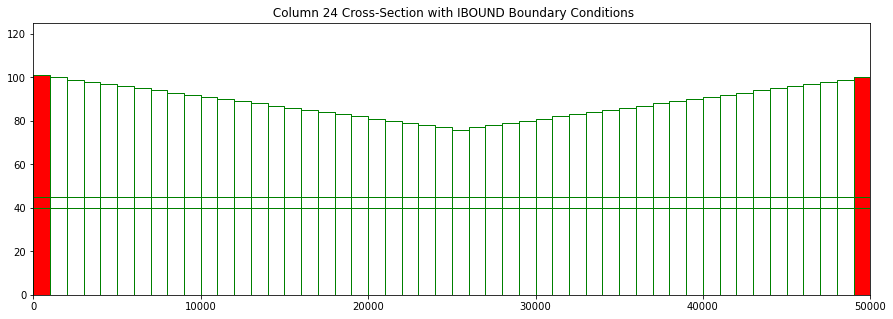

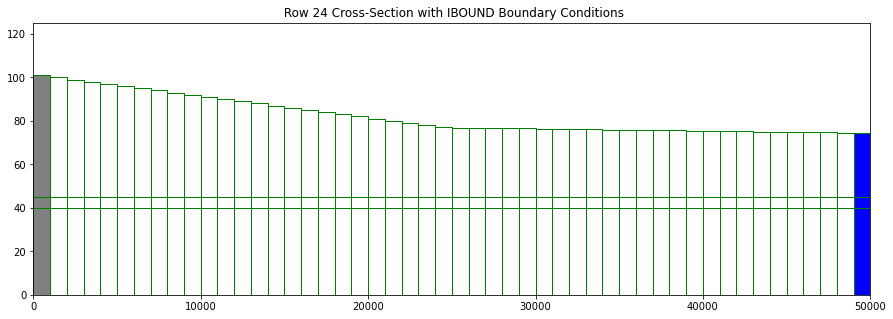

In [57]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'column': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title(' Column 24 Cross-Section with IBOUND Boundary Conditions')

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='gray', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title(' Row 24 Cross-Section with IBOUND Boundary Conditions')

flow and head map

[b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'              ET', b'  STREAM LEAKAGE', b'STREAM FLOW OUT ']
1


C:\Users\sitzk\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:255: UserWarning: No contour levels were found within the data range.
  contour_set = ax.tricontour(triang, plotarray, **kwargs)
C:\Users\sitzk\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\map.py:819: DeprecationWarning: plot_discharge() has been deprecated and will be replaced in version 3.3.5. Use plot_vector() instead, which should follow after postprocessing.get_specific_discharge()
  warnings.warn(
C:\Users\sitzk\miniconda3\envs\gwmod\lib\site-packages\flopy\plot\plotutil.py:1630: DeprecationWarning: centered_specific_discharge() has been deprecated and will be removed in version 3.3.5. Use postprocessing.get_specific_discharge() instead.
  warnings.warn(


IndexError: index 1 is out of bounds for axis 0 with size 1

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


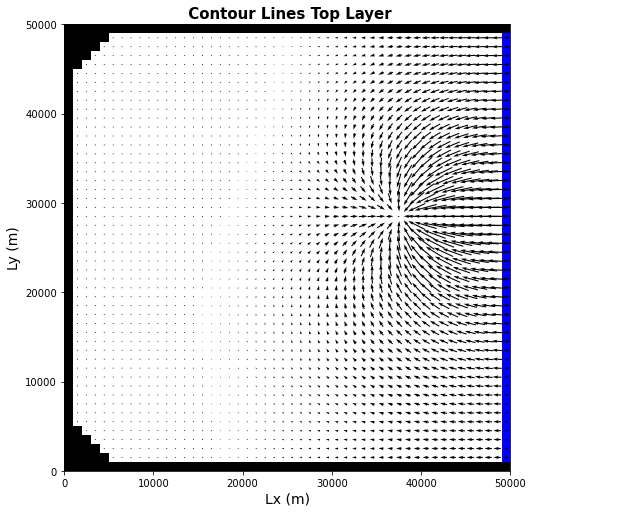

In [58]:
budgobj1 = bf.CellBudgetFile("Base_Code_1"+'.cbc')   #reads the cell budget file    

#Head - 3 layer model 
headobj3 = bf.HeadFile("Base_Code_1"+'.hds')    #reads the binary head file
times = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)
head3[head3==-9999] = np.nan

#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile("Base_Code_1"+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
#recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))

fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours
flows = modelmap.plot_discharge(frf3[0], fff3[0], head=head3) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title(' Contour Lines Top Layer', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)